## Install Julia

Run the first cell, then reload the page. In most computers, the shortcut is Ctrl + R. Your browswer may ask if you want to leave this page. Say yes.

Julia 1.10.4 will be installed, and you should be able to run the notebook.

In [ ]:
# @title CODE: Install Julia

%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.4"
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


**Please ignore:** "Unrecognized magic %%shell."

# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd48430 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, broadwell)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


## Installing packages
Get some tea, it'll take time.

In [ ]:
# @title CODE: Install packages

using Pkg
Pkg.add(PackageSpec(name="Rasters", version="0.11"))
Pkg.add(PackageSpec(name="HTTP", version="1.10"))
Pkg.add(PackageSpec(name="JSON", version="0.21"))
Pkg.add(PackageSpec(name="Glob", version="1.3"))
Pkg.add(PackageSpec(name="ArchGDAL", version="0.10.4"))
Pkg.add(PackageSpec(name="DataFrames", version="1.6.1"))
Pkg.add(PackageSpec(name="Statistics", version="0.10.4"))
Pkg.add(PackageSpec(name="GeoJSON", version="0.8.1"))
Pkg.add(PackageSpec(name="NighttimeLights", version="0.7.0"))

Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Adapt ─────────────────────── v4.0.4
   Installed LRUCache ──────────────────── v1.6.1
   Installed TableTraits ───────────────── v1.0.1
   Installed IntervalSets ──────────────── v0.7.10
   Installed OffsetArrays ──────────────── v1.14.0
   Installed ColorTypes ────────────────── v0.11.5
   Installed Tables ────────────────────── v1.11.1
   Installed RecipesBase ───────────────── v1.3.4
   Installed DataAPI ───────────────────── v1.16.0
   Installed FixedPointNumbers ─────────── v0.8.5
   Installed Setfield ──────────────────── v1.1.1
   Installed DimensionalData ───────────── v0.27.3
   Installed Rasters ───────────────────── v0.11.3
   Installed Extents ───────────────────── v0.1.3
   Installed StaticArraysCore ──────────── v1.4.3
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed ProgressMeter ─────────────── v1.10.0
   Installed DataValueInterfaces ───────── v1.0.0

In [ ]:
using NighttimeLights, GeoJSON, Rasters, Plots, Statistics, DataFrames, Dates, Glob, Base.Filesystem, HTTP, JSON

In [ ]:
# Define path constants
FIGURES_DIRECTORY = "figures"
TABLES_DIRECTORY = "tables"
VECTOR_DIRECTORY = "data/vector"
TABULAR_DIRECTORY = "data/tabular"
RASTER_DIRECTORY = "data/raster"

# Check and create folders using a loop
directories = [
    FIGURES_DIRECTORY,
    TABLES_DIRECTORY,
    VECTOR_DIRECTORY,
    TABULAR_DIRECTORY,
    RASTER_DIRECTORY
]

for path in directories
    if !isdir(path)
        mkpath(path)
        println("Created folder: $path")
    end
end


Created folder: figures
Created folder: tables
Created folder: data/vector
Created folder: data/tabular
Created folder: data/raster


In [ ]:
START_YEAR = 2017
END_YEAR = 2019

# Define your EOG credentials
USERNAME = "ayushpatnaik@gmail.com"
PASSWORD = "n3zaCXM5TtZV3Hb"
CLIENT_ID = "eogdata_oidc"
CLIENT_SECRET = "2677ad81-521b-4869-8480-6d05b9e57d48"

function download_link(link)
    """
    Function to download image from EOG using the API

    Parameters:
    -----------
    link :: String

    Returns:
    --------
    None

    Notes:
    ------
    Downloads image in RASTER_DIRECTORY
    """
    output_file = joinpath(RASTER_DIRECTORY, basename(link))
    if isfile(output_file)
        println("File $output_file already exists. Skipping download.")
        return
    end

    params = Dict(
        "client_id" => CLIENT_ID,
        "client_secret" => CLIENT_SECRET,
        "username" => USERNAME,
        "password" => PASSWORD,
        "grant_type" => "password"
    )
    token_url = "https://eogauth.mines.edu/auth/realms/master/protocol/openid-connect/token"
    response = HTTP.post(token_url, [], params)
    access_token_dict = JSON.parse(String(response.body))
    access_token = access_token_dict["access_token"]
    data_url = link
    auth = "Bearer " * access_token
    headers = Dict("Authorization" => auth)
    response = HTTP.get(data_url, headers)

    open(output_file, "w") do f
        write(f, response.body)
    end
    println("File $output_file downloaded successfully.")
end

base_url = "https://eogdata.mines.edu/nighttime_light/annual/v21/{}/"

for year in START_YEAR:END_YEAR
    url = string("https://eogdata.mines.edu/nighttime_light/annual/v21/", year, "/VNL_v21_npp_", year, "_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz")
    print(url)
    download_link(url)
end

https://eogdata.mines.edu/nighttime_light/annual/v21/2017/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif.gzFile data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz downloaded successfully.
https://eogdata.mines.edu/nighttime_light/annual/v21/2018/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.median_masked.dat.tif.gzFile data/raster/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz downloaded successfully.
https://eogdata.mines.edu/nighttime_light/annual/v21/2019/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.median_masked.dat.tif.gzFile data/raster/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz downloaded successfully.


In [ ]:
# Define the path for the RASTER_DIRECTORY
RASTER_DIRECTORY = "data/raster"

# Get the current working directory
current_dir = pwd()

# Find all .gz files in the data/raster folder
gz_files = glob("*.gz", joinpath(current_dir, RASTER_DIRECTORY))

for file in gz_files
    gz_path = joinpath(current_dir, RASTER_DIRECTORY, file)
    tif_path = replace(gz_path, ".gz" => "")

    # Skip extraction if the .tif file already exists
    if !isfile(tif_path)
        # Extract the .gz file using the run() function
        run(`gzip -d $gz_path`)
        println("Extracted: $gz_path")
    else
        println("Skipped: $gz_path (already exists)")
    end
end

println("Successfully processed all .gz files!")



Extracted: /content/data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz
Extracted: /content/data/raster/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz
Extracted: /content/data/raster/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz
Successfully processed all .gz files!


In [ ]:
function load_raster(year::Int)
    """
    Load a raster file based on the provided time identifier.

    Parameters:
    -----------
    year :: Int

    Returns:
    --------
    ArchGDAL.Dataset
    An opened raster file dataset ready for further operations.

    Example:
    --------
    raster_2014 = load_raster(2014)
    typeof(raster_2014) # ArchGDAL.Dataset

    Notes:
    ------
    Modify the path in the function if your file structure
    or naming convention differs.
    """
    raster_path = joinpath(RASTER_DIRECTORY, "VNL_v21_npp_$year*")
    raster_file = glob(raster_path)[1]
    Raster(raster_file, lazy = true)
end

load_raster (generic function with 1 method)

In [ ]:
raster = load_raster(2017)

╭───────────────────────────────╮
│ 86401×33601 Raster{Float32,2} │
├───────────────────────────────┴──────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(-180.00208333335, 179.99791954665002, 86401) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(74.99791666665, -65.00208445335001, 33601) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (-180.00208333335, 180.00208621335003), Y = (-65.00208445335001, 75.00208333335))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHE

In [ ]:
map_url = "https://gist.github.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson"

# Define the output file path
output_file_path = joinpath(VECTOR_DIRECTORY, "gdf_india36.geojson")

# Download the file using wget
run(`wget -O $output_file_path $map_url`)

--2024-06-29 12:20:57--  https://gist.github.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson
Resolving gist.github.com (gist.github.com)... 140.82.114.4
Connecting to gist.github.com (gist.github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson [following]
--2024-06-29 12:20:57--  https://gist.githubusercontent.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908761 (887K) [text/plain]
Saving

Process(`wget -O data/vector/gdf_india36.geojson https://gist.github.com/cmg777/19c25af8fcfe2291cfb6f9abf141d45a/raw/48e1489e97f975c5a2253d2068cf99a3c2d0cff3/gdf_india36.geojson`, ProcessExited(0))

In [ ]:
using GeoJSON
india_shapes = GeoJSON.read(joinpath(VECTOR_DIRECTORY, "gdf_india36.geojson"))

FeatureCollection with 36 Features

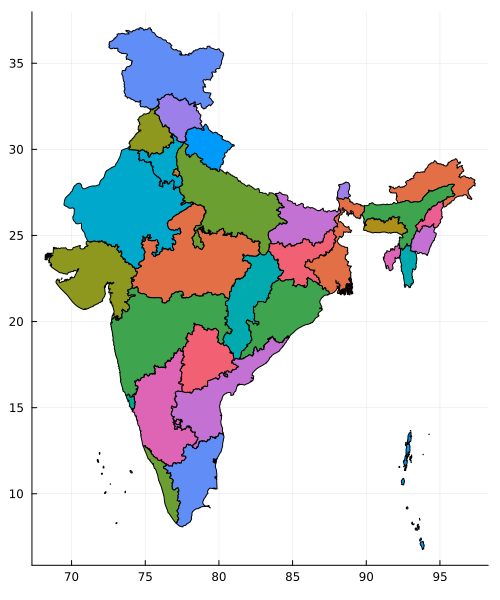

In [ ]:
plot(india_shapes.geometry)
plot!(size=(500,600))

In [ ]:
india_raster = crop(raster; to = india_shapes.geometry)

╭─────────────────────────────╮
│ 7010×7276 Raster{Float32,2} │
├─────────────────────────────┴────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(68.18958531885004, 97.39375221915003, 7010) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(37.072916363249995, 6.760416120749998, 7276) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (68.18958531885004, 97.39791888585003), Y = (6.760416120749998, 37.077083029949996))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHE

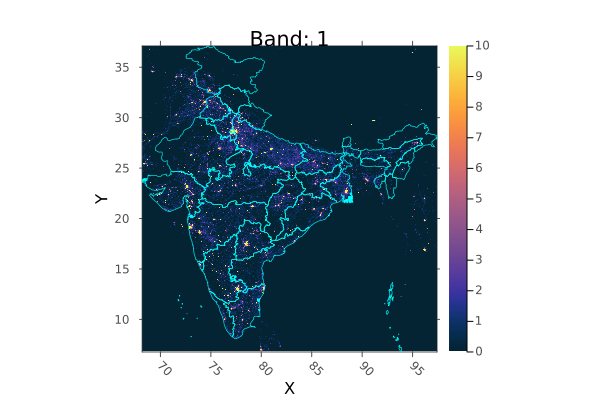

In [ ]:
plot(india_raster, clims= (0, 10),  color=:thermal)
# actual values are much higher than 10. Chosen 10 just for representation.

plot!(india_shapes.geometry; fillalpha=0, linewidth=0.6, linecolor=:cyan)

In [ ]:
delhi = india_shapes[findfirst(region -> region == "NCT of Delhi", india_shapes.region)]

Feature with 2D MultiPolygon geometry and 3 properties: (:geometry, :id, :region)

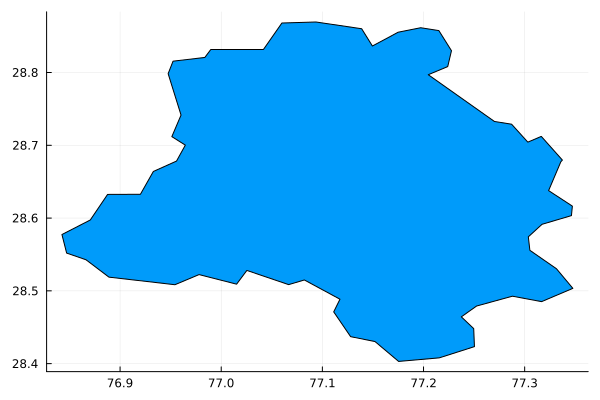

In [ ]:
plot(delhi.geometry)

In [ ]:
delhi_raster = crop(india_raster; to = delhi.geometry)

╭───────────────────────────╮
│ 120×111 Raster{Float32,2} │
├───────────────────────────┴──────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(76.84375205475004, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.864582964249998, 28.406249627249995, 111) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475004, 77.34375205875003), Y = (28.406249627249995, 28.86874963095))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WG

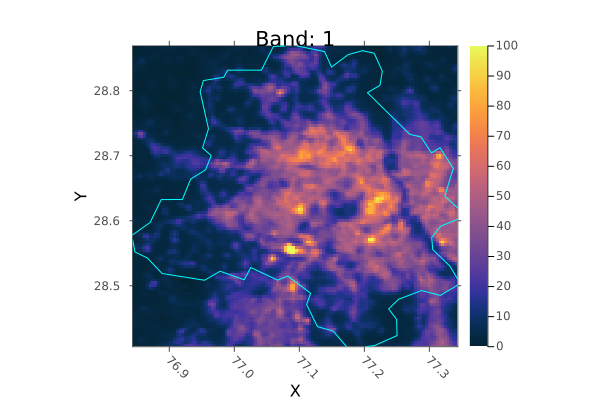

In [ ]:
plot(delhi_raster, clims= (0, 100),  color=:thermal)
plot!(delhi.geometry; fillalpha=0, linewidth=1, linecolor=:cyan)

In [ ]:
delhi_masked = mask(delhi_raster; with = delhi)

╭───────────────────────────────────────────╮
│ 120×111 Raster{Union{Missing, Float32},2} │
├───────────────────────────────────────────┴──────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(76.84375205475004, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.864582964249998, 28.406249627249995, 111) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475004, 77.34375205875003), Y = (28.406249627249995, 28.86874963095))
  missingval: missing

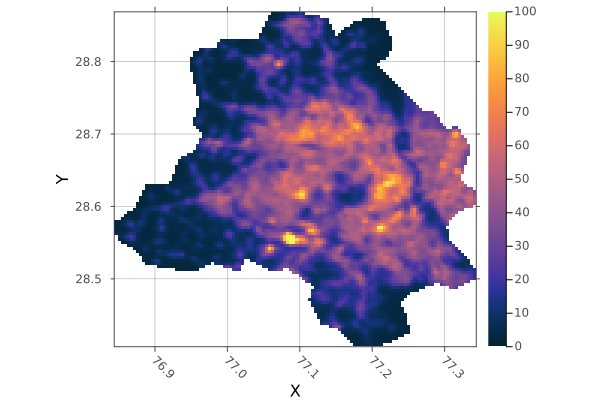

In [ ]:
plot(delhi_masked, clims= (0, 100),  color=:thermal)

In [ ]:
# intensity of light in Delhi
sum(skipmissing(delhi_masked))

# skipmissing create a vector of values which are not missing.

208524.72f0

In [ ]:
xlims = X(Rasters.Between(76.5536049, 77.5142033))
ylims = Y(Rasters.Between(28.2341611, 28.9333776))

delhi_bounds = xlims, ylims

↓ X Between((76.5536, 77.5142)), → Y Between((28.2342, 28.9334))

In [ ]:
around_delhi = raster[delhi_bounds...]

╭───────────────────────────╮
│ 229×167 Raster{Float32,2} │
├───────────────────────────┴──────────────────────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} LinRange{Float64}(76.55625205245002, 77.50625206005004, 229) ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} LinRange{Float64}(28.927082964750003, 28.235416292549996, 167) ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 4 entries:
  "units"    => ""
  "offset"   => 0.0
  "filepath" => "data/raster/VNL_v21_npp_2017_global_vcmslcfg_c202205302300.median_masked.dat.tif"
  "scale"    => 1.0
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.55625205245002, 77.51041872675005), Y = (28.235416292549996, 28.931249631450005))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID

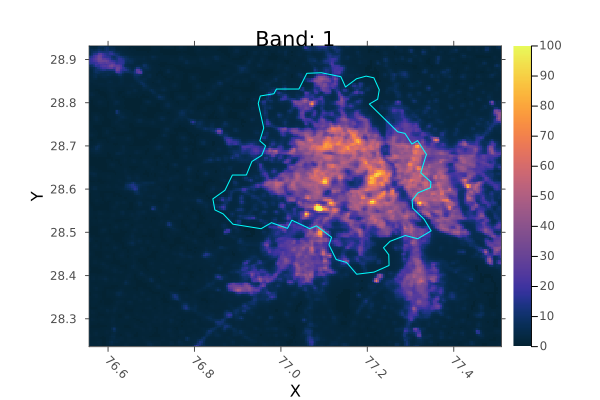

In [ ]:
plot(around_delhi, clims= (0, 100),  color=:thermal)
plot!(delhi.geometry; fillalpha=0, linewidth=1, linecolor=:cyan)

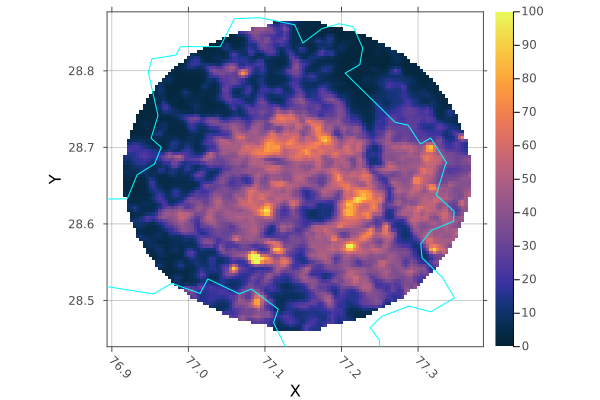

In [ ]:
ring_bounds, ring_mask = annular_ring(around_delhi, 22, 28.661030684972932, 77.14041127194707, 15)

plot(mask(around_delhi[ring_bounds...], with = ring_mask), clims= (0, 100),  color=:thermal)
plot!(delhi.geometry; fillalpha=0, linewidth=1, linecolor=:cyan)

Use both masks, geometry and ring.

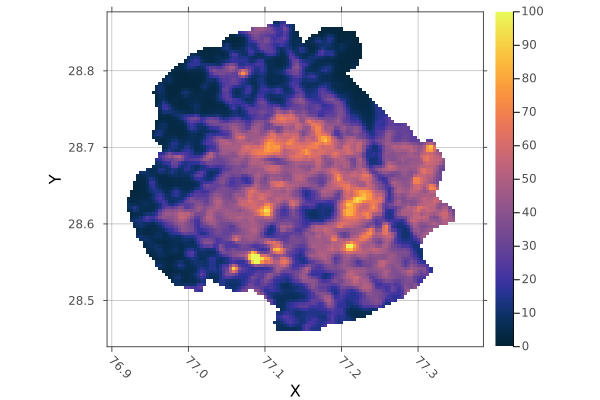

In [ ]:
plot(mask(mask(around_delhi[ring_bounds...], with = ring_mask), with = delhi.geometry), clims= (0, 100),  color=:thermal)

In [ ]:
rajiv_chowk_metro = around_delhi[X(Near(77.2192563)), Y(Near(28.6330402))]

93.597435f0

In [ ]:
function load_datacube(xlims = X(Rasters.Between(76.5536049, 77.5142033)), ylims = Y(Rasters.Between(28.2341611, 28.9333776)), start_year = 2017, end_year = 2019)
    lims = xlims, ylims
    raster_list = [load_raster(year)[lims...] for year in start_year:end_year]
    time = Ti(Date(start_year):Year(1):Date(end_year))
    raster_series = RasterSeries(raster_list, time)
    datacube = Rasters.combine(raster_series, time)
    return datacube
end

function load_datacube(geom, start_year = 2017, end_year = 2019)
    lims = xlims, ylims
    raster_list = [crop(load_raster(year); to = geom) for year in start_year:end_year]
    time = Ti(Date(start_year):Year(1):Date(end_year))
    raster_series = RasterSeries(raster_list, time)
    datacube = Rasters.combine(raster_series, time)
    return datacube
end


load_datacube (generic function with 5 methods)

In [ ]:
around_delhi_datacube = load_datacube(X(Rasters.Between(76.5536049, 77.5142033)), Y(Rasters.Between(28.2341611, 28.9333776)), START_YEAR, END_YEAR)

╭─────────────────────────────╮
│ 229×167×3 Raster{Float32,3} │
├─────────────────────────────┴────────────────────────────────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} LinRange{Float64}(76.55625205245002, 77.50625206005004, 229) ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} LinRange{Float64}(28.927082964750003, 28.235416292549996, 167) ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{Date} Date("2017-01-01"):Year(1):Date("2019-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.55625205245002, 77.51041872675005), Y = (28.235416292549996, 28.931249631450005), Ti = (Date("2017-01-01"), Date("2019-01-01")))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["E

In [ ]:
delhi_datacube = load_datacube(delhi.geometry, START_YEAR, END_YEAR)

╭─────────────────────────────╮
│ 120×111×3 Raster{Float32,3} │
├─────────────────────────────┴────────────────────────────────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} LinRange{Float64}(76.84375205475001, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} LinRange{Float64}(28.864582964249998, 28.40624962725, 111) ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{Date} Date("2017-01-01"):Year(1):Date("2019-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475001, 77.34375205875003), Y = (28.40624962725, 28.86874963095), Ti = (Date("2017-01-01"), Date("2019-01-01")))

  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]

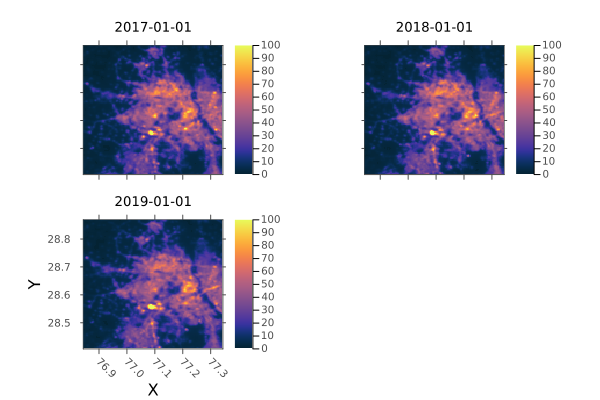

In [ ]:
p = plot(delhi_datacube, clims= (0, 100),  color=:thermal)

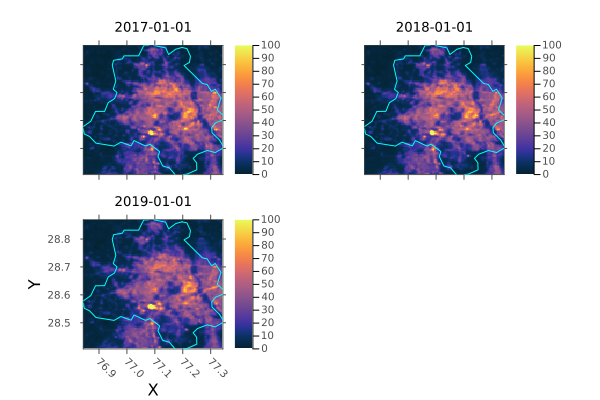

In [ ]:
for i in 1:(END_YEAR - START_YEAR + 1)
    plot!(p, delhi.geometry; fillalpha=0, linewidth=1, subplot = i, linecolor=:cyan)
end
display(p)

In [ ]:
delhi_datacube_mask = mask(delhi_datacube; with = delhi.geometry)

╭─────────────────────────────────────────────╮
│ 120×111×3 Raster{Union{Missing, Float32},3} │
├─────────────────────────────────────────────┴────────────────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} LinRange{Float64}(76.84375205475001, 77.33958539205003, 120) ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} LinRange{Float64}(28.864582964249998, 28.40624962725, 111) ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{Date} Date("2017-01-01"):Year(1):Date("2019-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (76.84375205475001, 77.34375205875003), Y = (28.40624962725, 28.86874963095), Ti = (Date("2017-01-01"), Date("2019-01-01")))
  missingval: missing
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT

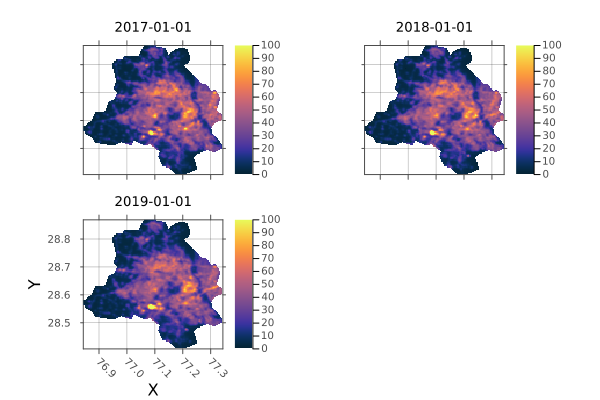

In [ ]:
plot(delhi_datacube_mask, clims= (0, 100),  color=:thermal)

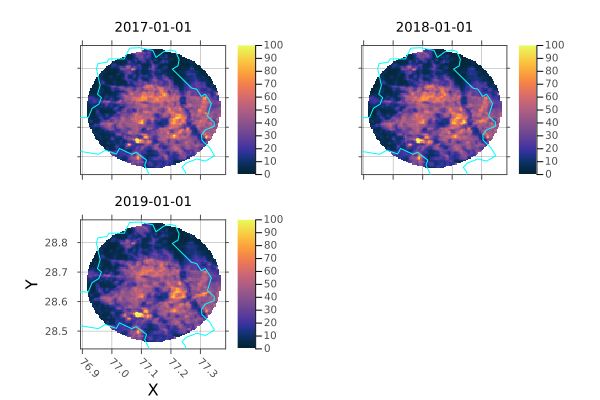

In [ ]:
p = plot(mask(around_delhi_datacube[ring_bounds...], with = ring_mask), clims= (0, 100),  color=:thermal)
for i in 1:(END_YEAR - START_YEAR + 1)
    plot!(p, delhi.geometry; fillalpha=0, linewidth=1, subplot = i, linecolor=:cyan)
end
display(p)